# Our Vision Model: DDS+VAE
This notebook explains the architecture, training pipeline, and visualization of our two-stage DDS+VAE vision model.

## Overview
The ProPoS **DDS+VAE** vision model integrates a Dynamic Feature Selection (DDS), Downscaling and Upscaling modules and U-Nets with a small Variational Autoencoder (VAE) to reconstruct environment observations in two training stages.

## Architecture Diagrams
- **DDS** Select sparse pixel mask
- **downscaling network** compresses input images to a compact representation.  
- **VAE** reconstructs the compact representation from the downscaled features.

<img src='imgs/DDS.png' width=800>

<img src='imgs/dds_vae_architecture.png' width=800>


## Loss Functions
We optimize a combination of:
- **Perceptual loss** for high-fidelity reconstruction of key features.  
- **KL divergence** with free bits to regularize the latent distribution.  
  
<img src='imgs/perceptual_loss.png' width = 800>

In [1]:
import sys
import os
from pathlib import Path


# Get the absolute path to the parent directory of the notebook
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

path = str(Path().cwd().parent)  

## Model Definition
We import and instantiate the `Vision` model class which contains the DDS downscale and VAE components.

In [2]:
import torch
from src.models.dds_vae import Vision

# Instantiate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vision = Vision(n_features_to_select=0.03, in_ch=3, out_ch=3, base_ch=16, alpha=1.0, delta=0.1).to(device)
print(vision)

Vision(
  (unet1): UNet(
    (inc): ConvBlock(
      (conv): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
    )
    (down1): Down(
      (down): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): ConvBlock(
          (conv): Sequential(
            (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
      )
    )
    (down2): Down(
      (down): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): ConvBlock(
          (conv): Sequential(
            (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(

## Stage 1: Train Full DDS+VAE
Train the entire model end-to-end to learn both DDS downscaling and VAE reconstruction.

In [ ]:
from src.train_dds_vae_stage1 import main as train_stage1  # end-to-end training script

# Customize parameters as needed
train_stage1(
    mask=0.03,  # feature selection ratio
    base_ch=16,
    dataset_name='car_racing_data_1024.h5',
    epochs=10,
    alpha=1.0,
    batch_size=128,
    path='trained_models'
)

## Stage 2: Fine-Tune miniVAE
Freeze the DDS network and fine-tune only the miniVAE component for a stronger latent representation.

In [ ]:
from src.train_dds_vae_satge2 import main as train_stage2  # miniVAE fine-tuning script

# Run stage 2 training
train_stage2(
    mask=0.03,
    base_ch=16,
    dataset_name='car_racing_data_1024.h5',
    epochs=5,
    alpha=1.0,
    batch_size=128,
    path='trained_models'
)

## Visualization of Trained Model
Load the trained weights and visualize the downscaled features and reconstructions on a sample batch.

In [3]:
import torch
from src.models.dds_vae import Vision
from src.utils.dataset import CarRacingDataset
from torch.utils.data import DataLoader

# Setup device & load weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vision = Vision(n_features_to_select=0.03, in_ch=3, out_ch=3, base_ch=16, alpha=1.0, delta=0.1).to(device)
vision.load_state_dict(torch.load(path+'/src/trained_models/vision_03_miniVAE.pth', map_location=device, weights_only=True))
vision.eval()

# Prepare data
dataset = CarRacingDataset(path+'/src/car_racing_data_1024.h5')
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_133424/1699799546.py:32: SyntaxWarning: invalid escape sequence '\m'
  titles    = ["${\mathbf{X}}$", "${g(\mathbf{X}; \mathbf{\Theta}_S)}$", "${f_{\mathrm{down}}(\mathbf{mask})}$",
/tmp/ipykernel_133424/1699799546.py:32: SyntaxWarning: invalid escape sequence '\m'
  titles    = ["${\mathbf{X}}$", "${g(\mathbf{X}; \mathbf{\Theta}_S)}$", "${f_{\mathrm{down}}(\mathbf{mask})}$",
/tmp/ipykernel_133424/1699799546.py:32: SyntaxWarning: invalid escape sequence '\m'
  titles    

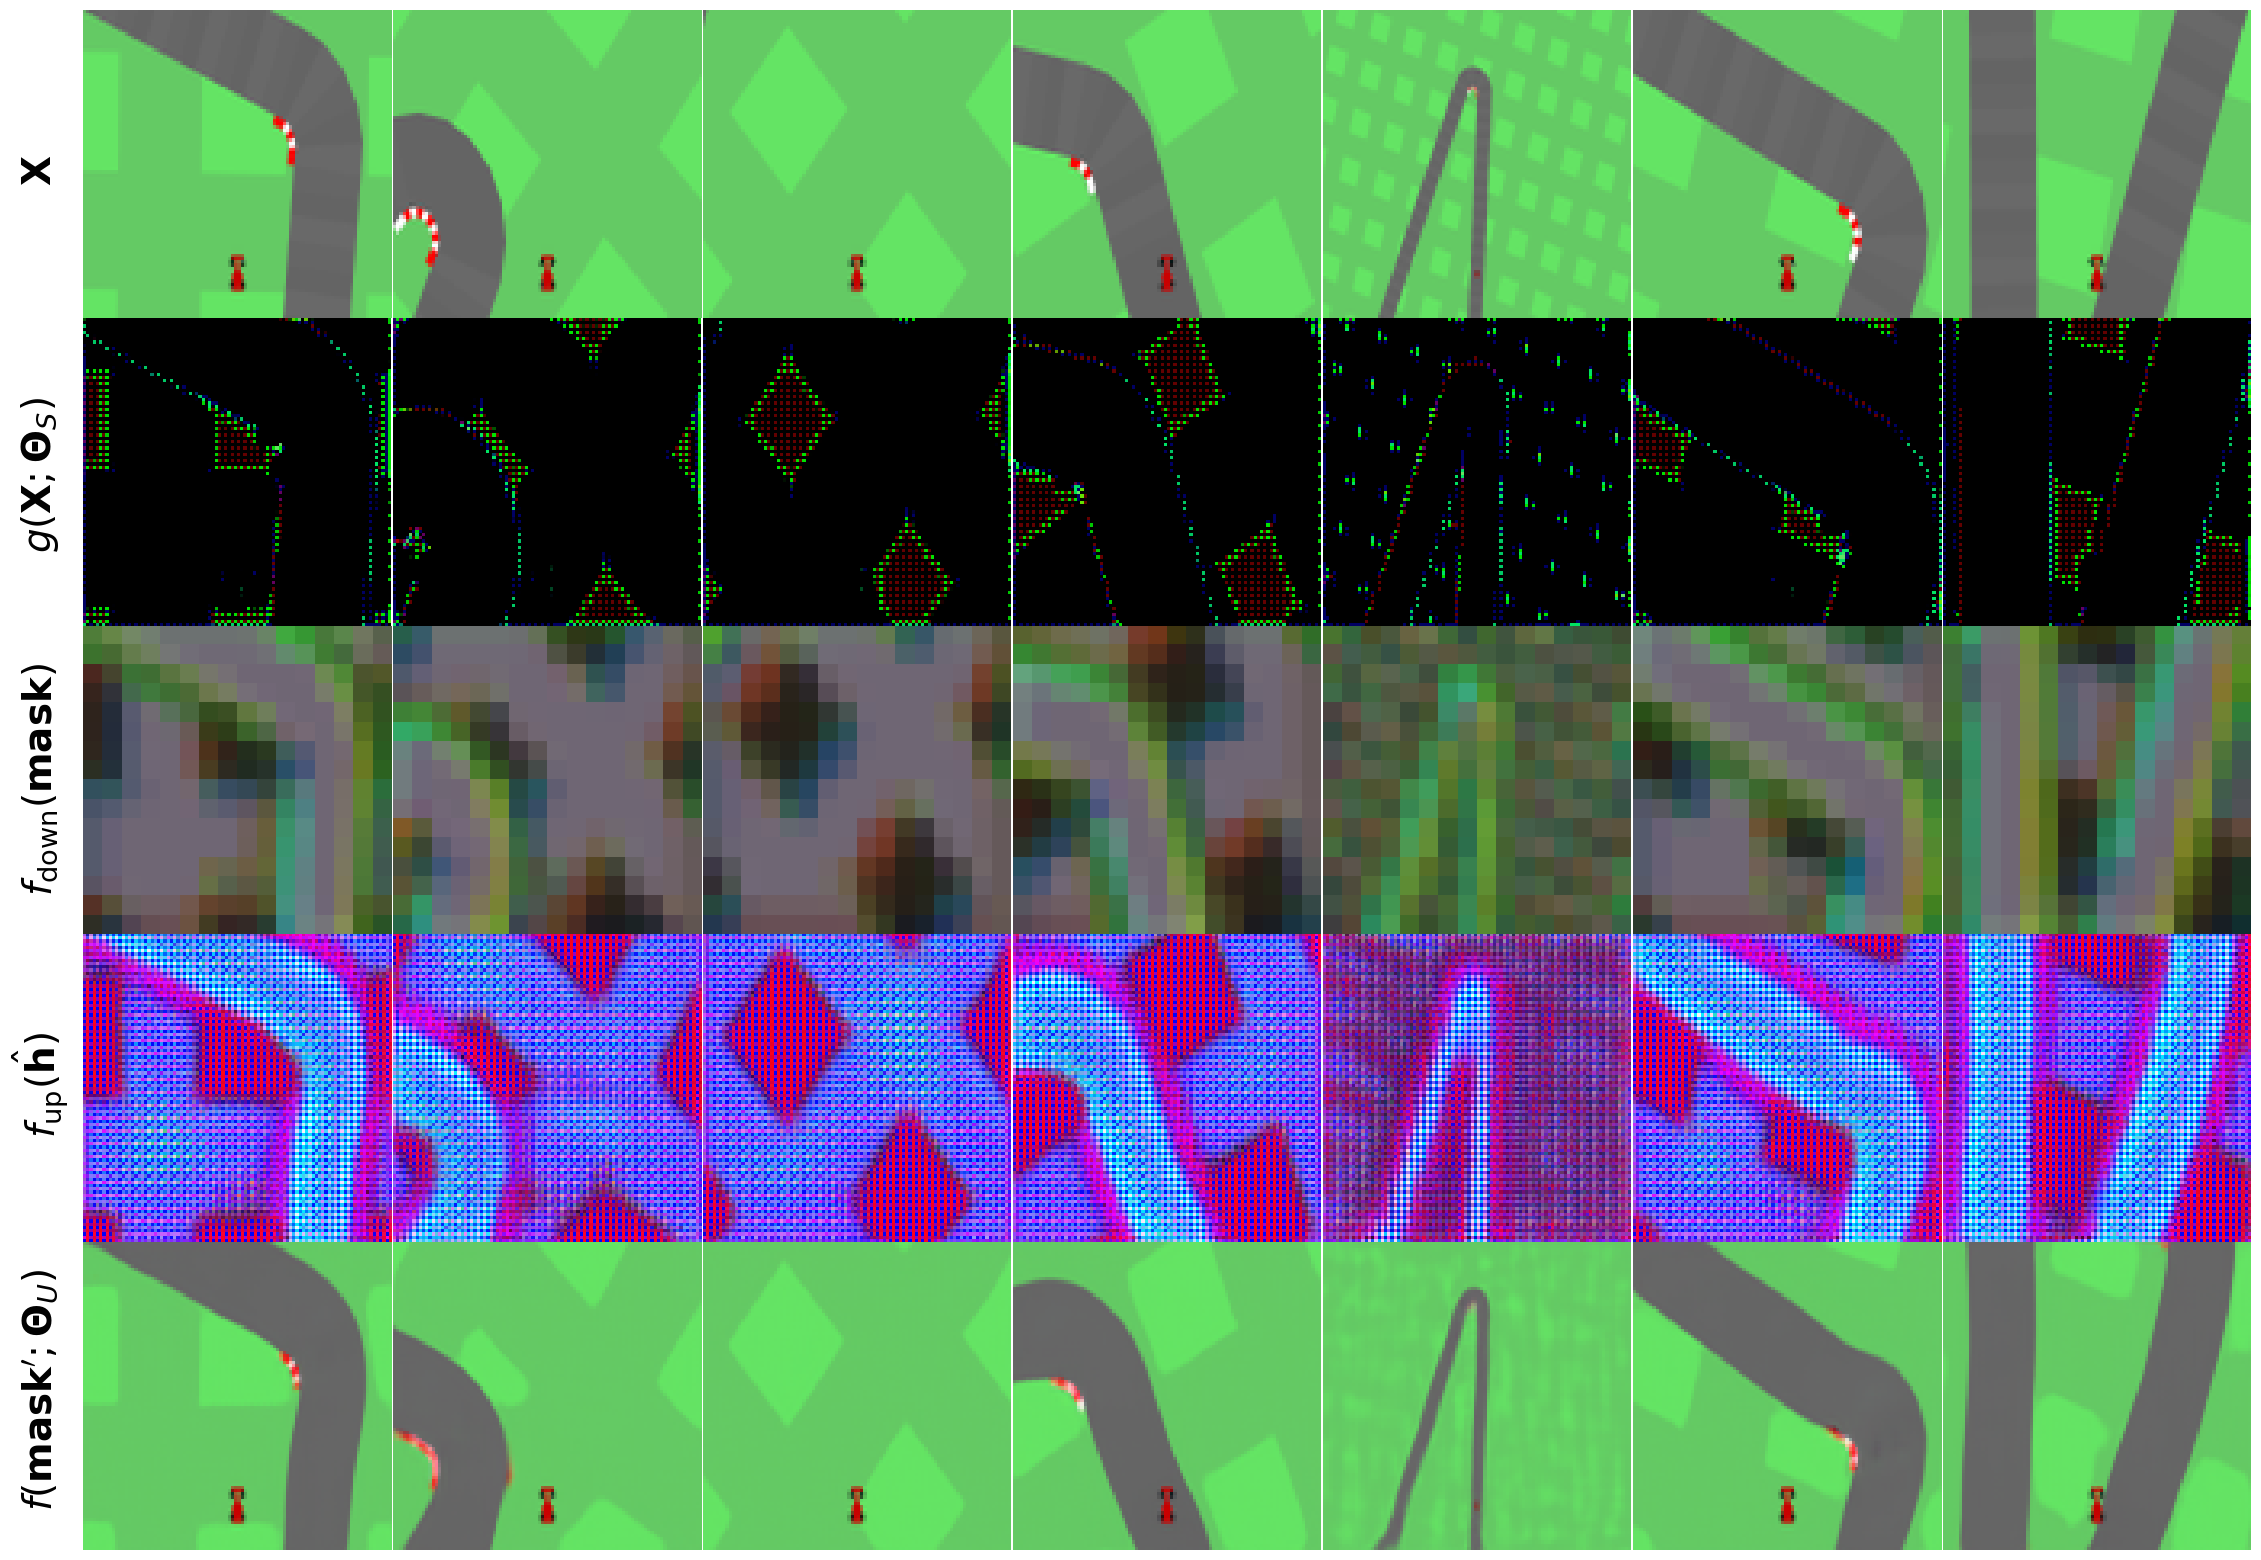

In [5]:
"""
Script Description:
-------------------
This script provides a function to visualize the various stages of processing 
inside a vision model (with downscale, encode, decode methods) in a transposed 
grid format. Useful for debugging and understanding model transformations.
"""

import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch import nn

# -------------------- Visualization of Vision Model Transformations ----------------------
def plot_vision_transposed(
    vision: nn.Module, 
    dataset: Dataset, 
    device: torch.device, 
    images: list[int]
) -> None:
    """
    Visualize the intermediate outputs of a vision model in a transposed grid.

    Args:
        vision (nn.Module): Vision model with `downscale`, `encode`, and `decode` methods.
        dataset (Dataset): Dataset containing images to visualize.
        device (torch.device): Torch device where the model is loaded ('cpu' or 'cuda').
        images (list[int]): List of indices of images to visualize.
    """
    vision.eval()  # Ensure model is in evaluation mode

    titles    = ["${\mathbf{X}}$", "${g(\mathbf{X}; \mathbf{\Theta}_S)}$", "${f_{\mathrm{down}}(\mathbf{mask})}$", 
                 "${f_{\mathrm{up}}(\hat{\mathbf{h}})}$", "${f(\mathbf{mask'}; \mathbf{\Theta}_U)}$"]
    num_rows  = len(titles)                        # Rows: transformations
    num_cols  = len(images)                        # Columns: selected images

    fig, axes = plt.subplots(
        num_rows, num_cols, 
        figsize=(4 * num_cols, 4 * num_rows),
        gridspec_kw={'wspace': 0, 'hspace': 0}
    )

    # Ensure axes is 2D array for consistent indexing
    if num_rows == 1:
        axes = [axes]

    # 1) Process each selected image
    for col, image_idx in enumerate(images):
        x = dataset[image_idx][0].unsqueeze(0).to(device)

        with torch.no_grad():
            mini_mask, mask, binary_mask   = vision.downscale(x)
            mask, mini_mask, z             = vision.encode(x)
            x_hat, mask_hat, mini_mask_hat = vision.decode(z)

        # 2) Collect transformation outputs
        plots = [x, mask, mini_mask, mask_hat, x_hat]

        # 3) Plot each transformation stage
        for row, img in enumerate(plots):
            img_np = img[0].permute(1, 2, 0).cpu().numpy()
            img_np = img_np[:, :, :3]       # Keep only RGB channels

            ax = axes[row][col] if num_cols > 1 else axes[row]
            ax.imshow(img_np)
            ax.axis("off")

    plt.subplots_adjust(wspace=0, hspace=0)

    # 4) Add vertical titles for each row (transformation)
    title_font = {'family': 'serif', 'size': 28}
    for row, title in enumerate(titles):
        fig.text(
            0.11, 0.8 - row * (0.61 / (num_rows - 1)),
            title,
            ha='center',
            va='center',
            fontproperties=title_font,
            rotation=90
        )

    plt.show()

# -------------------- Execution Example ----------------------
plot_vision_transposed(
    vision   = vision,
    dataset  = dataset,
    device   = device,
    images   = [120, 6952, 23487, 960, 6008, 2080, 6800]
)


## **Interactive Environment Exploration**

This section allows interaction with the environment while visualizing the VAE's reconstruction capabilities in real-time.
 
- **Controls**: Arrow keys control the car (↑: accelerate, ↓: brake, ←/→: steer)
- **Visualization**: The display shows the original environment observation alongside the VAE's reconstruction
- **Video Recording**: Optional video recording of the interaction session


In [4]:
import os
import gymnasium as gym
import pygame
import numpy as np
import torch
from torchvision import transforms
import cv2
from src.utils.utils import ensure_dir_exists, setup_video_writer, reset, get_action, preprocess_image
from src.utils.utils import TRANSFORM as transform

In [5]:
def run_car_racing(env_name, transform, device, scale=1, resolution=(96, 96), save_video=False, video_filename="car_racing_vision.mp4"):
    """Run the car racing environment with specified settings."""

    # --- Setup Directories and Video Writer ---
    ensure_dir_exists('renders')
    video_filepath = os.path.join('renders', video_filename)

    pygame.init()
    display_resolution = (resolution[0] * 4 * scale, resolution[1] * scale)
    screen = pygame.display.set_mode(display_resolution)
    clock = pygame.time.Clock()
    font = pygame.font.Font(None, 36)

    video_writer = setup_video_writer(video_filepath, display_resolution[::-1]) if save_video else None

    # --- Initialize Environment ---
    env = gym.make(env_name, render_mode='rgb_array')
    obs = reset(env)

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # --- Handle Actions ---
        keys = pygame.key.get_pressed()
        action = get_action(keys)
        obs, reward, done, info, _ = env.step(action)

        # --- Transform and Process Observation ---
        x = transform(obs).unsqueeze(0).to(device)

        with torch.no_grad():
            mini_mask, mask, binary_mask = vision.downscale(x)
            x_hat, mask_hat = vision.upscale(mini_mask)

        mse = torch.mean((x - x_hat) ** 2).item()

        images = [x, mask, mini_mask, x_hat]
        processed_images = [preprocess_image(img, resolution) for img in images]
        full_image = np.concatenate(processed_images, axis=0)
        full_image_resized = cv2.resize(full_image, (display_resolution[1], display_resolution[0]), interpolation=cv2.INTER_LINEAR)

        # --- Render and Display ---
        pygame.surfarray.blit_array(screen, full_image_resized)
        mse_text = font.render(f"MSE: {mse:.5f}", True, (255, 255, 255))
        screen.blit(mse_text, (10, 10))
        pygame.display.flip()

        if save_video and video_writer is not None:
            video_writer.write(cv2.cvtColor(full_image_resized, cv2.COLOR_RGB2BGR))

        clock.tick(30)
        if done:
            obs = reset(env)

    # --- Cleanup ---
    if save_video and video_writer is not None:
        video_writer.release()

    pygame.quit()
    env.close()

# --- Main Execution ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
run_car_racing(env_name="CarRacing-v3", transform=transform, device=device, scale=5, save_video=False)


In [6]:
def run_car_racing(env_name, transform, device, scale=1, resolution=(96, 96), save_video=False, video_filename="car_racing_miniVAE.mp4"):
    """Run the car racing environment with specified settings."""

    # --- Setup Directories and Video Writer ---
    ensure_dir_exists('renders')
    video_filepath = os.path.join('renders', video_filename)

    pygame.init()
    display_resolution = (resolution[0] * 4 * scale, resolution[1] * scale)
    screen = pygame.display.set_mode(display_resolution)
    clock = pygame.time.Clock()
    font = pygame.font.Font(None, 36)

    video_writer = setup_video_writer(video_filepath, display_resolution[::-1]) if save_video else None

    # --- Initialize Environment ---
    env = gym.make(env_name, render_mode='rgb_array')
    obs = reset(env)

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # --- Handle Actions ---
        keys = pygame.key.get_pressed()
        action = get_action(keys)
        obs, reward, done, info, _ = env.step(action)

        # --- Transform and Process Observation ---
        x = transform(obs).unsqueeze(0).to(device)

        with torch.no_grad():
            mask, mini_mask, z = vision.encode_eval(x)
            x_hat, mask_hat, mini_mask_hat = vision.decode(z)

        mse = torch.mean((mini_mask - mini_mask_hat) ** 2).item()

        images = [x, mini_mask, mini_mask_hat, x_hat]
        processed_images = [preprocess_image(img, resolution) for img in images]
        full_image = np.concatenate(processed_images, axis=0)
        full_image_resized = cv2.resize(full_image, (display_resolution[1], display_resolution[0]), interpolation=cv2.INTER_LINEAR)

        # --- Render and Display ---
        pygame.surfarray.blit_array(screen, full_image_resized)
        mse_text = font.render(f"MSE: {mse:.5f}", True, (255, 255, 255))
        screen.blit(mse_text, (10, 10))
        pygame.display.flip()

        if save_video and video_writer is not None:
            video_writer.write(cv2.cvtColor(full_image_resized, cv2.COLOR_RGB2BGR))

        clock.tick(30)
        if done:
            obs = reset(env)

    # --- Cleanup ---
    if save_video and video_writer is not None:
        video_writer.release()

    pygame.quit()
    env.close()

# --- Main Execution ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
run_car_racing(env_name="CarRacing-v3", transform=transform, device=device, scale=5, save_video=False)


In [7]:
def run_car_racing(env_name, transform, device, scale=1, resolution=(96, 96), save_video=False, video_filename="car_racing_miniVAE.mp4"):
    """Run the car racing environment with specified settings."""

    # --- Setup Directories and Video Writer ---
    ensure_dir_exists('renders')
    video_filepath = os.path.join('renders', video_filename)

    pygame.init()
    display_resolution = (resolution[0] * 4 * scale, resolution[1] * scale)
    screen = pygame.display.set_mode(display_resolution)
    clock = pygame.time.Clock()
    font = pygame.font.Font(None, 36)

    video_writer = setup_video_writer(video_filepath, display_resolution[::-1]) if save_video else None

    # --- Initialize Environment ---
    env = gym.make(env_name, render_mode='rgb_array')
    obs = reset(env)

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # --- Handle Actions ---
        keys = pygame.key.get_pressed()
        action = get_action(keys)
        obs, reward, done, info, _ = env.step(action)

        # --- Transform and Process Observation ---
        x = transform(obs).unsqueeze(0).to(device)

        with torch.no_grad():
            mask, mini_mask, z = vision.encode_eval(x)
            x_hat, mask_hat, mini_mask_hat = vision.decode(z)

        mse = torch.mean((mini_mask - mini_mask_hat) ** 2).item()

        images = [x, mask, mini_mask_hat, mask_hat, x_hat]
        processed_images = [preprocess_image(img, resolution) for img in images]
        full_image = np.concatenate(processed_images, axis=0)
        full_image_resized = cv2.resize(full_image, (display_resolution[1], display_resolution[0]), interpolation=cv2.INTER_LINEAR)

        # --- Render and Display ---
        pygame.surfarray.blit_array(screen, full_image_resized)
        mse_text = font.render(f"MSE: {mse:.5f}", True, (255, 255, 255))
        screen.blit(mse_text, (10, 10))
        pygame.display.flip()

        if save_video and video_writer is not None:
            video_writer.write(cv2.cvtColor(full_image_resized, cv2.COLOR_RGB2BGR))

        clock.tick(30)
        if done:
            obs = reset(env)

    # --- Cleanup ---
    if save_video and video_writer is not None:
        video_writer.release()

    pygame.quit()
    env.close()

# --- Main Execution ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
run_car_racing(env_name="CarRacing-v3", transform=transform, device=device, scale=5, save_video=False)


 ## **Interactive Latent Space Exploration**
 
 This section provides an interactive interface to explore the VAE's latent space and understand its learned representations.
 
 <img src="imgs/latent_exploration.png" width="900">
 
 ### Key Features:
 
 - **Latent Vector Manipulation**: Interactive sliders allow adjustment of individual dimensions in the latent space
 - **Real-time Image Generation**: The VAE decoder generates images from the modified latent vectors
 - **Random Sampling**: Generate random points in the latent space to explore its diversity
 - **Dimension Exploration**: A shift slider allows exploration of all latent dimensions (beyond those with dedicated sliders)

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, VBox, Button, Output, HBox, IntSlider

LATENT_SIZE = 32
vision.eval()

def generate_image(latent_vector):
    """
    Generate an image from a latent vector using the VAE decoder.
    
    Args:
        latent_vector: Vector in the latent space
    
    Returns:
        Generated image as numpy array
    """
    device = next(vision.parameters()).device
    with torch.no_grad():
        latent_tensor = torch.tensor(latent_vector, dtype=torch.float32).to(device).unsqueeze(0)
        generated_image = vision.decode(latent_tensor)[0].squeeze(0).cpu().numpy()
        return generated_image

# Create sliders for latent space dimensions
num_sliders = 8
sliders = [FloatSlider(value=0.0, min=-3.0, max=3.0, step=0.1, description=f'Latent {i+1}') for i in range(num_sliders)]

output = Output()

def update_image(change):
    """
    Update the displayed image based on the current slider values.
    """
    latent_vector = np.zeros(LATENT_SIZE)
    for i, slider in enumerate(sliders):
        latent_vector[i + shift_slider.value] = slider.value
    generated_image = generate_image(latent_vector)
    
    with output:
        output.clear_output(wait=True)
        plt.figure(figsize=(5, 5))
        plt.imshow(generated_image.transpose(1, 2, 0))
        plt.axis('off')
        plt.title('Generated Image')
        plt.show()

def update_slider_labels(shift_value):
    """
    Update slider labels based on the shift value.
    """
    for i, slider in enumerate(sliders):
        slider.description = f'Latent {i + 1 + shift_value}'

# Link sliders to update function
for slider in sliders:
    slider.observe(update_image, 'value')

def generate_random_latent(button):
    """
    Generate a random latent vector and update sliders.
    """
    latent_vector = np.random.uniform(-3.0, 3.0, size=LATENT_SIZE)
    for i, slider in enumerate(sliders):
        slider.value = latent_vector[i + shift_slider.value]
    update_image(None)

# Create buttons
random_button = Button(description='Random Vector', 
                      tooltip='Generate random latent vector values',
                      style={'button_color': '#3498db'})
random_button.on_click(generate_random_latent)

reset_button = Button(description='Reset Sliders', 
                     tooltip='Reset all sliders to zero',
                     style={'button_color': '#e74c3c'})
def reset_sliders(button):
    """
    Reset all sliders to zero.
    """
    for slider in sliders:
        slider.value = 0.0
    update_image(None)
reset_button.on_click(reset_sliders)

# Shift slider to adjust which latent dimensions the other sliders modify
shift_slider = IntSlider(value=0, min=0, max=LATENT_SIZE - num_sliders, step=1, 
                        description='SHIFT',
                        tooltip='Shift which latent dimensions are controlled by sliders')
shift_slider.observe(lambda change: update_slider_labels(shift_slider.value), 'value')
shift_slider.observe(update_image, 'value')

# Create a vertical box for sliders, shift slider, and buttons with padding
slider_box = VBox(sliders + [shift_slider, random_button, reset_button], layout={'margin': '30px 0 0 0'})

# Create a horizontal box to hold the image output and sliders
layout = HBox([output, slider_box])

# Display the layout
display(layout)

# Generate an initial image and set initial slider labels
update_slider_labels(shift_slider.value)
update_image(None)

 ## **Latent Space Visualization with UMAP**

 This section uses UMAP (Uniform Manifold Approximation and Projection) to visualize the high-dimensional latent space in 2D.
 
 UMAP is particularly effective at preserving both local and global structure of the data, making it ideal for understanding the organization of the latent space.

In [28]:
import torch
from tqdm import tqdm
LATENT_SIZE = 32
def get_latent_space(model,dataloader, batch, latent_size, max_batch):
    """Extracts latent vectors from dataset using the VAE model."""
    latent_space = []
    with torch.no_grad():
        for i in tqdm(range(max_batch), desc='Extracting latent space'):
            images, actions, rewards, dones = next(iter(dataloader))
            mu, logvar, z = model.encode(images.squeeze(0).to(device))
            latent_space.append(z)
    print(f"Latent space shape: {latent_space[0].shape}")
    latent_space = torch.stack(latent_space[:-1]).reshape((max_batch-1)*batch,latent_size)
    return latent_space.detach().cpu().numpy()


latent_space = get_latent_space(vision, dataloader, 128, LATENT_SIZE, max_batch=120)

Extracting latent space: 100%|██████████| 120/120 [00:19<00:00,  6.15it/s]

Latent space shape: torch.Size([128, 32])


/home/bruno/miniconda3/envs/pytorch/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


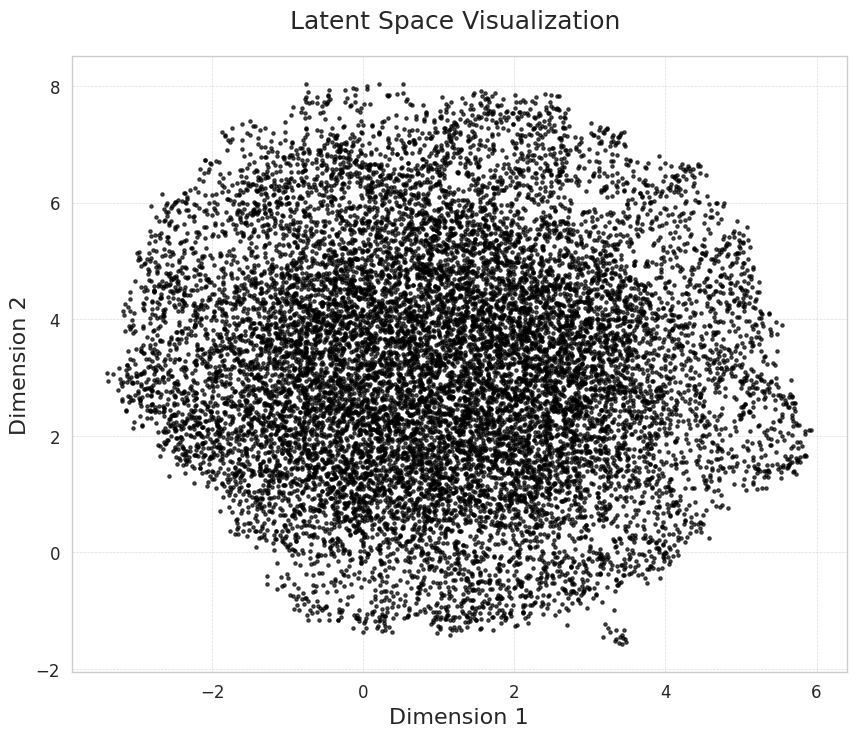

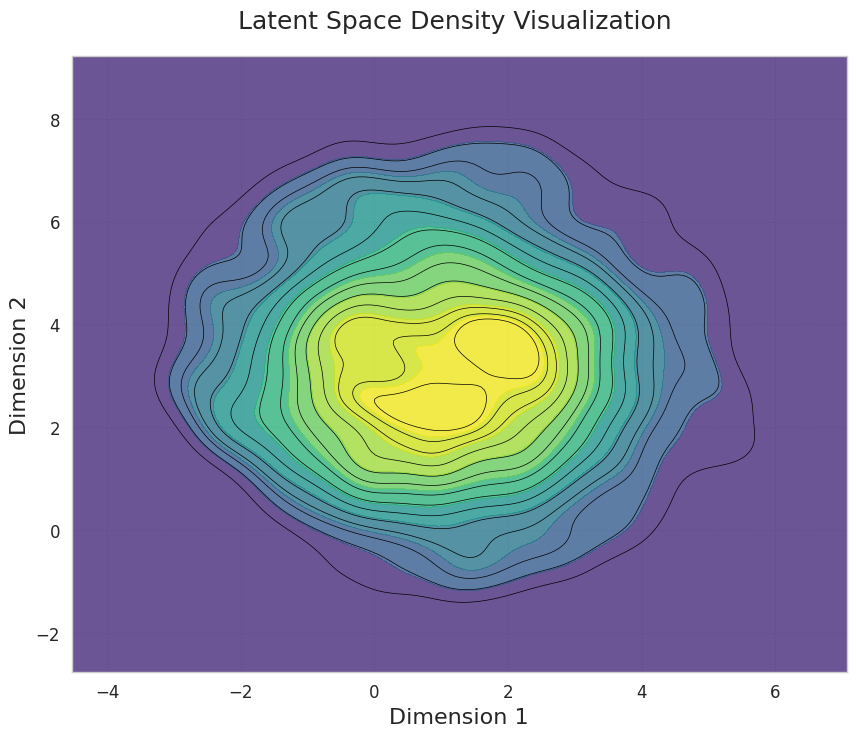

In [ ]:
import umap.umap_ as umap  

umap_model = umap.UMAP(n_components=100, min_dist=0.5)
latent_2d_umap = umap_model.fit_transform(latent_space)

from src.utils.plots import plot_latent_space, plot_latent_space_density

plot_latent_space(latent_2d_umap, 'UMAP', save=False)
plot_latent_space_density(latent_2d_umap, 'UMAP', save=False)